# GETTING 3 SEPARATE DF'S TO LATER COMBINE INTO 1



Overview Steps of Following Work:

1. Top 5 Short Haul Dataset: df_top5short_final
2. Top 5 Medium Haul Dataset: df_top5med_final
3. Top 5 Long Haul Dataset: df_top5long_final
4. Combined Total Dataset: df_all_final
5. Add Columns defining Short, Med, Long Haul
6. Filter out data for Long Haul
7. Plot STD for airfare in long Haul flights

In [2]:
#Import Packages
import snowflake.connector
import pandas as pd

# 1. TOP5 SHORT HAUL

### Short Haul DF

In [3]:
# DATA GRAIN:
#expedia
#date: April 2021-March 2022
#fare_type: Economy and ECONOMY
#departure_stops =1
#duration_hrsint <=3
#Top 3 CXR: AA, UA, DW
#TOP 5 SHORT FLIGHTS
# 0	DFWORD	1644927
# 1	ORDDFW	1638829
# 2	ORDIAH	1154915
# 3	IAHORD	1125903
# 4	DFWATL	1091099
    
try:
    ctx= snowflake.connector.connect(user='CMU',
                                     password="ql2_analytics",
                                     account="zk56677",
                                     database='QL2_PROD',
                                     schema='public',
                                     warehouse='CMU_WAREHOUSE',
                                     role='SYSADMIN' )
    cursor = ctx.cursor()
    cur = cursor.execute(""" 
    WITH df1 as(
    SELECT 
         MARKET, SITE, CXR, QTS, QL2_QTS, DEPARTURE_DATE, QL2_DDATE, DEPARTURE_STOPS,FARE_TYPE, FARE, 
         FLIGHT_NUMBER, DEPARTURE_TIME, ROUTE, YEAR_MONTH, DURATION_FLIGHT,
         LEFT(DURATION_FLIGHT,CHARINDEX(':',DURATION_FLIGHT)-1) AS DURATION_HRS,
         RIGHT(DURATION_FLIGHT,CHARINDEX(':', (REVERSE(DURATION_FLIGHT))) - 1) AS DURATION_MIN,
         CAST(DURATION_HRS AS FLOAT)DURATION_HRS_FLT,
         CAST(DURATION_MIN AS FLOAT)DURATION_MIN_FLT
     FROM CAPSTONE_RAW_AIRFARE_V
    
    ),
     df2 as(
         SELECT *, EXTRACT(MONTH FROM QTS) AS MONTH, EXTRACT(YEAR FROM QTS) AS YEAR 
             FROM df1 WHERE (
                 DURATION_HRS_FLT <=3 
                 AND DEPARTURE_STOPS = 0
                 AND (FARE_TYPE = 'ECONOMY'OR FARE_TYPE = 'Economy') 
          )
     ), 
     df3 AS(
    SELECT 
         MARKET, SITE, CXR, QTS, QL2_QTS, DEPARTURE_DATE, QL2_DDATE, DEPARTURE_STOPS,FARE_TYPE, FARE, 
         FLIGHT_NUMBER, DEPARTURE_TIME, ROUTE, YEAR_MONTH, DURATION_FLIGHT, MONTH, YEAR,
        CASE WHEN DURATION_MIN_FLT >= 30 
            THEN DURATION_HRS_FLT + 1 
            ELSE DURATION_HRS_FLT END AS DURATION_HRSINT
        FROM df2
        WHERE DURATION_HRSINT <= 3 ORDER BY DURATION_HRSINT DESC
        )
    SELECT * FROM df3
        WHERE 
        (CXR = 'AA' OR CXR = 'UA' OR CXR = 'DL') 
        AND  (MARKET = 'DFWORD' 
            OR MARKET = 'ORDDFW' 
            OR MARKET = 'ORDIAH' 
            OR MARKET = 'IAHORD' 
            OR MARKET = 'DFWATL')
    ;
    
 
    """)

    df_top5short_final = cur.fetch_pandas_all()
    
except Exception as e:
    print("failed connecting to QL2_PROD",e)


In [4]:
df_top5short_final = df_top5short_final.dropna()

### Med Haul DF

In [5]:
#Splitting the departure_date into new columns of year/month
    
# 0	ATLDEN	832415
# 1	DFWLAS	500648
# 2	EWRIAH	366561
# 3	IAHEWR	348468
# 4	LAXHNL	332463
try:
    ctx= snowflake.connector.connect(user='CMU',
                                     password="ql2_analytics",
                                     account="zk56677",
                                     database='QL2_PROD',
                                     schema='public',
                                     warehouse='CMU_WAREHOUSE',
                                     role='SYSADMIN' )
    cursor = ctx.cursor()
    cur = cursor.execute(""" 
    WITH df1 as(
    SELECT 
         MARKET, SITE, CXR, QTS, QL2_QTS, DEPARTURE_DATE, QL2_DDATE, DEPARTURE_STOPS,FARE_TYPE, FARE, 
         FLIGHT_NUMBER, DEPARTURE_TIME, ROUTE, YEAR_MONTH, DURATION_FLIGHT,
         LEFT(DURATION_FLIGHT,CHARINDEX(':',DURATION_FLIGHT)-1) AS DURATION_HRS,
         RIGHT(DURATION_FLIGHT,CHARINDEX(':', (REVERSE(DURATION_FLIGHT))) - 1) AS DURATION_MIN,
         CAST(DURATION_HRS AS FLOAT)DURATION_HRS_FLT,
         CAST(DURATION_MIN AS FLOAT)DURATION_MIN_FLT
     FROM CAPSTONE_RAW_AIRFARE_V
    
    ),
     df2 as(
         SELECT *, EXTRACT(MONTH FROM QTS) AS MONTH, EXTRACT(YEAR FROM QTS) AS YEAR 
             FROM df1 WHERE (
                 (DURATION_HRS_FLT >= 3 AND DURATION_HRS_FLT <=6)
                 AND DEPARTURE_STOPS = 0
                 AND (FARE_TYPE = 'ECONOMY'OR FARE_TYPE = 'Economy') 
          )
     ), 
     df3 AS(
    SELECT 
         MARKET, SITE, CXR, QTS, QL2_QTS, DEPARTURE_DATE, QL2_DDATE, DEPARTURE_STOPS,FARE_TYPE, FARE, 
         FLIGHT_NUMBER, DEPARTURE_TIME, ROUTE, YEAR_MONTH, DURATION_FLIGHT, MONTH, YEAR,
        CASE WHEN DURATION_MIN_FLT >= 30 
            THEN DURATION_HRS_FLT + 1 
            ELSE DURATION_HRS_FLT END AS DURATION_HRSINT
        FROM df2
        WHERE (DURATION_HRSINT >= 3 AND DURATION_HRSINT <=6) ORDER BY DURATION_HRSINT DESC
        )
    SELECT * FROM df3
        WHERE 
        (CXR = 'AA' OR CXR = 'UA' OR CXR = 'DL') 
        AND  (MARKET = 'ATLDEN' 
            OR MARKET = 'DFWLAS' 
            OR MARKET = 'EWRIAH' 
            OR MARKET = 'IAHEWR' 
            OR MARKET = 'LAXHNL')
 
      ;
 
    """)

    df_top5med_final = cur.fetch_pandas_all()
    
except Exception as e:
    print("failed connecting to QL2_PROD",e)


In [6]:
df_top5med_final = df_top5med_final.dropna()

In [ ]:
df_top5med_final

### Long Haul DF

In [7]:
#Splitting the departure_date into new columns of year/month
# 0	EZEMIA	25349
# 1	JFKSFO	25128
# 2	MIAEZE	23597
# 3	LHRJFK	14548
# 4	MIAGRU	14450

try:
    ctx= snowflake.connector.connect(user='CMU',
                                     password="ql2_analytics",
                                     account="zk56677",
                                     database='QL2_PROD',
                                     schema='public',
                                     warehouse='CMU_WAREHOUSE',
                                     role='SYSADMIN' )
    cursor = ctx.cursor()
    cur = cursor.execute(""" 
         WITH df1 as(
    SELECT 
         MARKET, SITE, CXR, QTS, QL2_QTS, DEPARTURE_DATE, QL2_DDATE, DEPARTURE_STOPS,FARE_TYPE, FARE, 
         FLIGHT_NUMBER, DEPARTURE_TIME, ROUTE, YEAR_MONTH, DURATION_FLIGHT,
         LEFT(DURATION_FLIGHT,CHARINDEX(':',DURATION_FLIGHT)-1) AS DURATION_HRS,
         RIGHT(DURATION_FLIGHT,CHARINDEX(':', (REVERSE(DURATION_FLIGHT))) - 1) AS DURATION_MIN,
         CAST(DURATION_HRS AS FLOAT)DURATION_HRS_FLT,
         CAST(DURATION_MIN AS FLOAT)DURATION_MIN_FLT
     FROM CAPSTONE_RAW_AIRFARE_V
    
    ),
     df2 as(
         SELECT *, EXTRACT(MONTH FROM QTS) AS MONTH, EXTRACT(YEAR FROM QTS) AS YEAR 
             FROM df1 WHERE (
                 DURATION_HRS_FLT >=5 
                 AND DEPARTURE_STOPS = 0
                 AND (FARE_TYPE = 'ECONOMY'OR FARE_TYPE = 'Economy') 
          )
     ), 
     df3 AS(
    SELECT 
         MARKET, SITE, CXR, QTS, QL2_QTS, DEPARTURE_DATE, QL2_DDATE, DEPARTURE_STOPS,FARE_TYPE, FARE, 
         FLIGHT_NUMBER, DEPARTURE_TIME, ROUTE, YEAR_MONTH, DURATION_FLIGHT, MONTH, YEAR,
        CASE WHEN DURATION_MIN_FLT >= 30 
            THEN DURATION_HRS_FLT + 1 
            ELSE DURATION_HRS_FLT END AS DURATION_HRSINT
        FROM df2
        WHERE DURATION_HRSINT >6 ORDER BY DURATION_HRSINT DESC
        )
        
        SELECT * FROM df3
         WHERE 
         (CXR = 'AA' OR CXR = 'UA' OR CXR = 'DL') 
            AND  (MARKET = 'EZEMIA' 
             OR MARKET = 'JFKSFO' 
             OR MARKET = 'MIAEZE' 
             OR MARKET = 'LHRJFK' 
             OR MARKET = 'MIAGRU')

     
      ;
 
    """)

    df_top5long_final = cur.fetch_pandas_all()
    
except Exception as e:
    print("failed connecting to QL2_PROD",e)


In [8]:
df_top5long_final = df_top5long_final.dropna()

### Combining all 3 dataset

In [9]:
#Combining short, med, long haul dfs together
short_med = pd.concat([df_top5short_final, df_top5med_final], axis=0)
df_all = pd.concat([short_med, df_top5long_final], axis=0)

### Adding Column HAUL_TYPE

In [10]:
df_all['HAUL_TYPE'] = df_all['DURATION_HRSINT'].apply(lambda x: 'short'if x <= 3 else ('medium' if (x >3 and x <=6) else 'long'))


In [30]:
df_all

MARKET SITE CXR                 QTS  QL2_QTS DEPARTURE_DATE  QL2_DDATE  \
0     ORDDFW  EXP  UA 2022-02-02 00:20:00     7337     2022-02-26       7361   
1     ORDDFW  EXP  AA 2022-02-02 00:20:00     7337     2022-02-10       7345   
2     ORDDFW  EXP  AA 2022-02-02 00:20:00     7337     2022-02-10       7345   
3     ORDDFW  EXP  UA 2022-02-02 00:20:00     7337     2022-02-10       7345   
4     ORDIAH  EXP  UA 2022-02-02 00:20:00     7337     2022-02-13       7348   
...      ...  ...  ..                 ...      ...            ...        ...   
2898  JFKSFO  EXP  DL 2021-10-31 09:28:00     7243     2021-11-21       7264   
2899  JFKSFO  EXP  DL 2021-10-31 09:28:00     7243     2021-11-21       7264   
2900  JFKSFO  EXP  UA 2021-10-31 09:28:00     7243     2021-11-21       7264   
2901  JFKSFO  EXP  AA 2021-10-31 09:28:00     7243     2021-11-21       7264   
2902  JFKSFO  EXP  AA 2021-10-31 09:28:00     7243     2021-11-21       7264   

      DEPARTURE_STOPS FARE_TYPE    FARE FLIGHT_NUMBER DEPARTURE_TIME  \
0                   0   ECONOMY  118.60          6087          15:35   
1                   0   ECONOMY  148.60          2754          07:00   
2                   0   ECONOMY  220.60          1106          11:25   
3                   0   ECONOMY  227.60          6309          19:35   
4                   0   ECONOMY   88.60          2675          06:00   
...               ...       ...     ...           ...            ...   
2898                0   ECONOMY  258.39           343          09:05   
2899                0   ECONOMY  258.39           442          11:05   
2900                0   ECONOMY  268.40           523          16:55   
2901                0   ECONOMY  283.40          9354          19:15   
2902                0   ECONOMY  338.41            76          07:00   

                           ROUTE    YEAR_MONTH DURATION_FLIGHT  MONTH  YEAR  \
0     15:35 - ORD :: 18:31 - DFW   ORDDFW20222            2:56      2  2022   
1     07:00 - ORD :: 09:37 - DFW   ORDDFW20222            2:37      2  2022   
2     11:25 - ORD :: 14:00 - DFW   ORDDFW20222            2:35      2  2022   
3     19:35 - ORD :: 22:30 - DFW   ORDDFW20222            2:55      2  2022   
4     06:00 - ORD :: 08:55 - IAH   ORDIAH20222            2:55      2  2022   
...                          ...           ...             ...    ...   ...   
2898  09:05 - JFK :: 12:44 - SFO  JFKSFO202111            6:39     10  2021   
2899  11:05 - JFK :: 14:39 - SFO  JFKSFO202111            6:34     10  2021   
2900  16:55 - JFK :: 20:41 - SFO  JFKSFO202111            6:46     10  2021   
2901  19:15 - JFK :: 23:00 - SFO  JFKSFO202111            6:45     10  2021   
2902  07:00 - JFK :: 10:38 - SFO  JFKSFO202111            6:38     10  2021   

      DURATION_HRSINT HAUL_TYPE  
0                 3.0     short  
1                 3.0     short  
2                 3.0     short  
3                 3.0     short  
4                 3.0     short  
...               ...       ...  
2898              7.0      long  
2899              7.0      long  
2900              7.0      long  
2901              7.0      long  
2902              7.0      long  

[10843330 rows x 19 columns]

# 7. cleaning data

In [11]:
a = df_all

In [29]:
b = df_all

In [12]:
# check uniqueness of each column
#a['CURRENCY'].unique()
#a['RDATE'].unique()

In [30]:
import time
import datetime as dt

# transforming type of DATE and QTS
a['tDATE'] = pd.to_datetime(a['DEPARTURE_DATE'])
a['tqts'] = pd.to_datetime(a['QTS'])
# calculating time till Departure
a['re'] = a['tDATE'] - a['tqts']
a

KeyboardInterrupt: 

In [31]:
import time
import datetime as dt

# transforming type of DATE and QTS
b['tDATE'] = pd.to_datetime(b['DEPARTURE_DATE'])
b['tqts'] = pd.to_datetime(b['QTS'])
# calculating time till Departure
b['re'] = b['tDATE'] - b['tqts']
b

MARKET SITE CXR                 QTS  QL2_QTS DEPARTURE_DATE  QL2_DDATE  \
0     IAHORD  EXP  UA 2022-02-17 15:09:00     7352     2022-03-15       7378   
1     ORDIAH  EXP  UA 2022-02-16 03:25:00     7351     2022-03-12       7375   
2     ORDIAH  EXP  UA 2022-02-16 03:25:00     7351     2022-03-06       7369   
3     ORDIAH  EXP  AA 2022-02-16 03:25:00     7351     2022-03-06       7369   
4     ORDIAH  EXP  UA 2022-02-16 03:25:00     7351     2022-03-06       7369   
...      ...  ...  ..                 ...      ...            ...        ...   
2763  JFKSFO  EXP  DL 2021-08-03 09:17:00     7154     2021-10-28       7240   
2764  JFKSFO  EXP  DL 2021-08-03 09:17:00     7154     2021-10-28       7240   
2765  JFKSFO  EXP  DL 2021-08-03 09:17:00     7154     2021-10-21       7233   
2766  JFKSFO  EXP  DL 2021-08-03 09:17:00     7154     2021-10-21       7233   
2767  JFKSFO  EXP  DL 2021-08-03 09:16:00     7154     2021-09-03       7185   

      DEPARTURE_STOPS FARE_TYPE    FARE  ...    YEAR_MONTH DURATION_FLIGHT  \
0                   0   economy  103.60  ...   IAHORD20223         2:44:00   
1                   0   economy  103.60  ...   ORDIAH20223         2:50:00   
2                   0   economy  118.60  ...   ORDIAH20223         2:57:00   
3                   0   economy  138.60  ...   ORDIAH20223         2:53:00   
4                   0   economy  172.60  ...   ORDIAH20223         2:50:00   
...               ...       ...     ...  ...           ...             ...   
2763                0   economy  198.40  ...  JFKSFO202110         6:49:00   
2764                0   economy  238.67  ...  JFKSFO202110          7:4:00   
2765                0   economy  198.40  ...  JFKSFO202110         6:44:00   
2766                0   economy  238.67  ...  JFKSFO202110          7:4:00   
2767                0   economy  198.40  ...   JFKSFO20219         6:31:00   

     MONTH  YEAR DURATION_HRSINT  HAUL_TYPE      tDATE                tqts  \
0        2  2022             3.0      short 2022-03-15 2022-02-17 15:09:00   
1        2  2022             3.0      short 2022-03-12 2022-02-16 03:25:00   
2        2  2022             3.0      short 2022-03-06 2022-02-16 03:25:00   
3        2  2022             3.0      short 2022-03-06 2022-02-16 03:25:00   
4        2  2022             3.0      short 2022-03-06 2022-02-16 03:25:00   
...    ...   ...             ...        ...        ...                 ...   
2763     8  2021             7.0       long 2021-10-28 2021-08-03 09:17:00   
2764     8  2021             7.0       long 2021-10-28 2021-08-03 09:17:00   
2765     8  2021             7.0       long 2021-10-21 2021-08-03 09:17:00   
2766     8  2021             7.0       long 2021-10-21 2021-08-03 09:17:00   
2767     8  2021             7.0       long 2021-09-03 2021-08-03 09:16:00   

                   re DaysTillDeparture  
0    25 days 08:51:00            1month  
1    23 days 20:35:00            1month  
2    17 days 20:35:00            1month  
3    17 days 20:35:00            1month  
4    17 days 20:35:00            1month  
...               ...               ...  
2763 85 days 14:43:00          2-4month  
2764 85 days 14:43:00          2-4month  
2765 78 days 14:43:00          2-4month  
2766 78 days 14:43:00          2-4month  
2767 30 days 14:44:00            1month  

[10909463 rows x 23 columns]

In [14]:
# calculate days till departure
a['DaysTillDeparture'] = a['re'].dt.components.days

In [32]:
# calculate days till departure
b['DaysTillDeparture'] = b['re'].dt.components.days

In [51]:
a

MARKET SITE CXR                 QTS  QL2_QTS DEPARTURE_DATE  QL2_DDATE  \
0     DFWORD  EXP  UA 2022-02-17 19:10:00     7352     2022-03-09       7372   
1     ORDIAH  EXP  UA 2022-02-17 19:10:00     7352     2022-03-06       7369   
2     ORDDFW  EXP  AA 2022-02-17 19:10:00     7352     2022-03-13       7376   
3     ORDDFW  EXP  UA 2022-02-17 19:10:00     7352     2022-03-13       7376   
4     ORDDFW  EXP  AA 2022-02-17 19:10:00     7352     2022-03-13       7376   
...      ...  ...  ..                 ...      ...            ...        ...   
2594  JFKSFO  EXP  DL 2022-01-19 05:18:00     7323     2022-04-04       7398   
2595  JFKSFO  EXP  DL 2022-01-19 05:18:00     7323     2022-04-04       7398   
2596  JFKSFO  EXP  DL 2022-01-19 05:18:00     7323     2022-04-25       7419   
2597  JFKSFO  EXP  AA 2022-01-20 02:46:00     7324     2022-01-22       7326   
2598  JFKSFO  EXP  AA 2022-01-22 19:45:00     7326     2022-02-09       7344   

      DEPARTURE_STOPS FARE_TYPE   FARE  ...   YEAR_MONTH DURATION_FLIGHT  \
0                   0   ECONOMY  162.6  ...  DFWORD20223            2:32   
1                   0   ECONOMY  138.6  ...  ORDIAH20223            2:50   
2                   0   ECONOMY  162.6  ...  ORDDFW20223            2:30   
3                   0   ECONOMY  162.6  ...  ORDDFW20223            2:41   
4                   0   ECONOMY  194.6  ...  ORDDFW20223            2:30   
...               ...       ...    ...  ...          ...             ...   
2594                0   ECONOMY  188.6  ...  JFKSFO20224            6:44   
2595                0   ECONOMY  318.6  ...  JFKSFO20224            6:43   
2596                0   ECONOMY  161.6  ...  JFKSFO20224            6:44   
2597                0   ECONOMY  238.6  ...  JFKSFO20221            6:53   
2598                0   ECONOMY   69.6  ...  JFKSFO20222            6:44   

     MONTH  YEAR DURATION_HRSINT  HAUL_TYPE      tDATE                tqts  \
0        2  2022             3.0      short 2022-03-09 2022-02-17 19:10:00   
1        2  2022             3.0      short 2022-03-06 2022-02-17 19:10:00   
2        2  2022             3.0      short 2022-03-13 2022-02-17 19:10:00   
3        2  2022             3.0      short 2022-03-13 2022-02-17 19:10:00   
4        2  2022             3.0      short 2022-03-13 2022-02-17 19:10:00   
...    ...   ...             ...        ...        ...                 ...   
2594     1  2022             7.0       long 2022-04-04 2022-01-19 05:18:00   
2595     1  2022             7.0       long 2022-04-04 2022-01-19 05:18:00   
2596     1  2022             7.0       long 2022-04-25 2022-01-19 05:18:00   
2597     1  2022             7.0       long 2022-01-22 2022-01-20 02:46:00   
2598     1  2022             7.0       long 2022-02-09 2022-01-22 19:45:00   

                   re DaysTillDeparture  
0    19 days 04:50:00                19  
1    16 days 04:50:00                16  
2    23 days 04:50:00                23  
3    23 days 04:50:00                23  
4    23 days 04:50:00                23  
...               ...               ...  
2594 74 days 18:42:00                74  
2595 74 days 18:42:00                74  
2596 95 days 18:42:00                95  
2597  1 days 21:14:00                 1  
2598 17 days 04:15:00                17  

[10525269 rows x 23 columns]

In [15]:
#fixing all of the -1 values for the DaysTillDeparture
a.loc[(a["DaysTillDeparture"] == -1), "DaysTillDeparture" ] = 0

In [33]:
#fixing all of the -1 values for the DaysTillDeparture
b.loc[(b["DaysTillDeparture"] == -1), "DaysTillDeparture" ] = 0

In [16]:
pd.options.display.max_rows = 4000

In [17]:
#see the distribution of daystilldeparture values
dtd_distr = a['DaysTillDeparture'].value_counts()
df_dtd_distr = pd.DataFrame(dtd_distr)
df_dtd_distr.index.name = 'numdays_beforedep'

print(df_dtd_distr.sort_values('numdays_beforedep'))

                   DaysTillDeparture
numdays_beforedep                   
0                             534841
1                             376121
2                             345462
3                             342214
4                             343857
5                             340367
6                             339669
7                             332917
8                             333117
9                             336875
10                            334859
11                            335783
12                            338967
13                            347773
14                            340386
15                            339648
16                            341433
17                            342365
18                            341338
19                            340102
20                            338590
21                            331223
22                            329730
23                            330709
24                            330732
2

In [18]:
a['DaysTillDeparture'] = a['DaysTillDeparture'].apply(lambda x: '1month'if x <= 30 else ('2-4month' if (x > 30 and x <=119) else '4+month'))


In [19]:
a.loc[a['DaysTillDeparture'] == "4+month"]

MARKET SITE CXR                 QTS  QL2_QTS DEPARTURE_DATE  QL2_DDATE  \
17595  ORDDFW  EXP  UA 2022-04-14 09:34:00     7408     2022-10-11       7588   
21536  DFWORD  EXP  UA 2021-04-14 05:42:00     7043     2021-08-19       7170   
21545  IAHORD  EXP  UA 2021-04-21 05:50:00     7050     2021-08-21       7172   
21546  IAHORD  EXP  UA 2021-04-21 05:50:00     7050     2021-08-21       7172   
21547  IAHORD  EXP  UA 2021-04-21 05:50:00     7050     2021-08-21       7172   
...       ...  ...  ..                 ...      ...            ...        ...   
2534   JFKSFO  EXP  DL 2021-08-04 08:10:00     7155     2021-12-16       7289   
2610   JFKSFO  EXP  AA 2021-10-12 18:09:00     7224     2022-02-10       7345   
2611   JFKSFO  EXP  AA 2021-10-12 18:09:00     7224     2022-02-10       7345   
2612   JFKSFO  EXP  AA 2021-10-12 18:09:00     7224     2022-02-10       7345   
2613   JFKSFO  EXP  AA 2021-10-12 18:09:00     7224     2022-02-10       7345   

       DEPARTURE_STOPS FARE_TYPE   FARE  ...    YEAR_MONTH DURATION_FLIGHT  \
17595                0   ECONOMY  205.6  ...  ORDDFW202210            2:35   
21536                0   ECONOMY  143.4  ...   DFWORD20218            2:31   
21545                0   ECONOMY  157.4  ...   IAHORD20218            2:40   
21546                0   ECONOMY  157.4  ...   IAHORD20218            2:33   
21547                0   ECONOMY  157.4  ...   IAHORD20218            2:44   
...                ...       ...    ...  ...           ...             ...   
2534                 0   ECONOMY  408.4  ...  JFKSFO202112            6:49   
2610                 0   ECONOMY   98.4  ...   JFKSFO20222            6:41   
2611                 0   ECONOMY   98.4  ...   JFKSFO20222            6:45   
2612                 0   ECONOMY  118.4  ...   JFKSFO20222            6:34   
2613                 0   ECONOMY  126.4  ...   JFKSFO20222            6:49   

      MONTH  YEAR DURATION_HRSINT  HAUL_TYPE      tDATE                tqts  \
17595     4  2022             3.0      short 2022-10-11 2022-04-14 09:34:00   
21536     4  2021             3.0      short 2021-08-19 2021-04-14 05:42:00   
21545     4  2021             3.0      short 2021-08-21 2021-04-21 05:50:00   
21546     4  2021             3.0      short 2021-08-21 2021-04-21 05:50:00   
21547     4  2021             3.0      short 2021-08-21 2021-04-21 05:50:00   
...     ...   ...             ...        ...        ...                 ...   
2534      8  2021             7.0       long 2021-12-16 2021-08-04 08:10:00   
2610     10  2021             7.0       long 2022-02-10 2021-10-12 18:09:00   
2611     10  2021             7.0       long 2022-02-10 2021-10-12 18:09:00   
2612     10  2021             7.0       long 2022-02-10 2021-10-12 18:09:00   
2613     10  2021             7.0       long 2022-02-10 2021-10-12 18:09:00   

                     re DaysTillDeparture  
17595 179 days 14:26:00           4+month  
21536 126 days 18:18:00           4+month  
21545 121 days 18:10:00           4+month  
21546 121 days 18:10:00           4+month  
21547 121 days 18:10:00           4+month  
...                 ...               ...  
2534  133 days 15:50:00           4+month  
2610  120 days 05:51:00           4+month  
2611  120 days 05:51:00           4+month  
2612  120 days 05:51:00           4+month  
2613  120 days 05:51:00           4+month  

[25135 rows x 23 columns]

### Cleaning other variables

In [20]:
# cast all string entry in FARE_TYPE column to lower case
a['FARE_TYPE'] = a['FARE_TYPE'].apply(lambda x: str.lower(x))

In [21]:
# clean the data/type of DURATION

# first convert to string
def convert_to_string (x):
    string = str(x).split('\n')[0].split(' ')[-1] + ':00'
    return string
a['DURATION_FLIGHT'] = a['DURATION_FLIGHT'].apply(convert_to_string)
a['DURATION_FLIGHT']

0       2:44:00
1       2:50:00
2       2:57:00
3       2:53:00
4       2:50:00
         ...   
2763    6:49:00
2764     7:4:00
2765    6:44:00
2766     7:4:00
2767    6:31:00
Name: DURATION_FLIGHT, Length: 10909463, dtype: object

In [22]:
a = a.dropna()

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns

# visual_overview = c 
# #Count of flights v/s pandemic
# plt.figure(figsize = (15, 10))
# plt.title('Count of flights with  Pandemic time')
# colors = sns.color_palette('bright')[0:5]
# plt.pie(x= 'Pandemic', data =visual_overview)

In [62]:
Long = b[b['HAUL_TYPE']=='long']

In [35]:
Long["CXR"].value_counts()

UA    966939
AA    165244
DL     97595
Name: CXR, dtype: int64

In [49]:
Long["MARKET"].value_counts()

EZEMIA    31515
MIAEZE    30205
JFKSFO    27648
LHRJFK    17793
MIAGRU    17468
Name: MARKET, dtype: int64

In [64]:
Long.dropna(axis=0,how='any') 

QL2_QTS                QL2_DDATE  \
                                     mean         std         mean   
DaysTillDeparture CXR MARKET                                         
0                 AA  EZEMIA  7201.056604  215.108666  7201.896226   
                      JFKSFO  7280.750799   92.167778  7281.421725   
                      LHRJFK  7264.802469   65.264473  7265.765432   
                      MIAEZE  7354.692982   36.152547  7355.692982   
                      MIAGRU  7315.781818   23.160224  7316.781818   
                  DL  EZEMIA  7129.016216  208.310405  7129.697297   
                      JFKSFO  7297.538642   91.731468  7298.117096   
                      LHRJFK  7367.991202   56.114457  7368.967742   
                      MIAEZE  7357.362069   67.980879  7358.339080   
                      MIAGRU  7365.000000   35.422281  7366.000000   
                  UA  JFKSFO  7293.485714   28.857022  7294.342857   
1                 AA  EZEMIA  7257.281588  186.772551  7259.281588   
                      JFKSFO  7254.500000  150.564018  7256.500000   
                      LHRJFK  7136.333333   12.426755  7138.333333   
                      MIAEZE  7356.329268   36.556489  7358.329268   
                      MIAGRU  7318.104478   26.829503  7320.104478   
                  DL  EZEMIA  7202.179487  202.398180  7204.179487   
                      JFKSFO  7271.952381  104.872331  7273.952381   
                      LHRJFK  7361.142857   61.097512  7363.142857   
                      MIAEZE  7362.431818   41.005342  7364.431818   
                      MIAGRU  7357.119205   35.422954  7359.119205   
                  UA  JFKSFO  7292.250000   12.841988  7294.250000   
2                 AA  EZEMIA  7260.860806  185.741070  7263.860806   
                      JFKSFO  7277.253086  110.406584  7280.253086   
                      LHRJFK  7275.524510   57.489210  7278.524510   
                      MIAEZE  7355.887029   36.831090  7358.887029   
                      MIAGRU  7316.750000   24.677604  7319.750000   
                  DL  EZEMIA  7225.267544  202.102829  7228.267544   
                      JFKSFO  7294.244526   92.797361  7297.244526   
                      LHRJFK  7355.090698   55.631938  7358.090698   
                      MIAEZE  7365.662983   45.001015  7368.662983   
                      MIAGRU  7363.284946   35.987227  7366.284946   
                  UA  JFKSFO  7295.695652   19.636318  7298.695652   
3                 AA  EZEMIA  7259.137184  187.295906  7263.137184   
                      JFKSFO  7147.406250  163.576727  7151.406250   
                      LHRJFK  7136.333333   12.426755  7140.333333   
                      MIAEZE  7351.775578   41.402672  7355.775578   
                      MIAGRU  7315.769231   21.064479  7319.769231   
                  DL  EZEMIA  7190.218341  209.368422  7194.218341   
                      JFKSFO  7244.008696  100.154398  7248.008696   
                      LHRJFK  7360.161290   73.700790  7364.161290   
                      MIAEZE  7353.546053   54.982820  7357.546053   
                      MIAGRU  7355.294118   35.778169  7359.294118   
4                 AA  EZEMIA  7260.235714  187.184099  7265.235714   
                      JFKSFO  7195.347826   89.918958  7200.347826   
                      LHRJFK  7136.333333   12.426755  7141.333333   
                      MIAEZE  7349.708447   44.536281  7354.708447   
                      MIAGRU  7323.969072   32.093760  7328.969072   
                  DL  EZEMIA  7223.000000  203.518305  7228.000000   
                      JFKSFO  7291.963636  103.570283  7296.963636   
                      LHRJFK  7394.240741   28.746646  7399.240741   
                      MIAEZE  7365.312169   45.925969  7370.312169   
                      MIAGRU  7363.220513   36.406462  7368.220513   
5                 AA  EZEMIA  7259.982206  186.597264  7265.982206   
                      JFKSFO  7147.805556  1

In [66]:
Long.reset_index()

DaysTillDeparture CXR  MARKET      QL2_QTS                QL2_DDATE  \
                                           mean         std         mean   
0                    0  AA  EZEMIA  7201.056604  215.108666  7201.896226   
1                    0  AA  JFKSFO  7280.750799   92.167778  7281.421725   
2                    0  AA  LHRJFK  7264.802469   65.264473  7265.765432   
3                    0  AA  MIAEZE  7354.692982   36.152547  7355.692982   
4                    0  AA  MIAGRU  7315.781818   23.160224  7316.781818   
5                    0  DL  EZEMIA  7129.016216  208.310405  7129.697297   
6                    0  DL  JFKSFO  7297.538642   91.731468  7298.117096   
7                    0  DL  LHRJFK  7367.991202   56.114457  7368.967742   
8                    0  DL  MIAEZE  7357.362069   67.980879  7358.339080   
9                    0  DL  MIAGRU  7365.000000   35.422281  7366.000000   
10                   0  UA  JFKSFO  7293.485714   28.857022  7294.342857   
11                   1  AA  EZEMIA  7257.281588  186.772551  7259.281588   
12                   1  AA  JFKSFO  7254.500000  150.564018  7256.500000   
13                   1  AA  LHRJFK  7136.333333   12.426755  7138.333333   
14                   1  AA  MIAEZE  7356.329268   36.556489  7358.329268   
15                   1  AA  MIAGRU  7318.104478   26.829503  7320.104478   
16                   1  DL  EZEMIA  7202.179487  202.398180  7204.179487   
17                   1  DL  JFKSFO  7271.952381  104.872331  7273.952381   
18                   1  DL  LHRJFK  7361.142857   61.097512  7363.142857   
19                   1  DL  MIAEZE  7362.431818   41.005342  7364.431818   
20                   1  DL  MIAGRU  7357.119205   35.422954  7359.119205   
21                   1  UA  JFKSFO  7292.250000   12.841988  7294.250000   
22                   2  AA  EZEMIA  7260.860806  185.741070  7263.860806   
23                   2  AA  JFKSFO  7277.253086  110.406584  7280.253086   
24                   2  AA  LHRJFK  7275.524510   57.489210  7278.524510   
25                   2  AA  MIAEZE  7355.887029   36.831090  7358.887029   
26                   2  AA  MIAGRU  7316.750000   24.677604  7319.750000   
27                   2  DL  EZEMIA  7225.267544  202.102829  7228.267544   
28                   2  DL  JFKSFO  7294.244526   92.797361  7297.244526   
29                   2  DL  LHRJFK  7355.090698   55.631938  7358.090698   
30                   2  DL  MIAEZE  7365.662983   45.001015  7368.662983   
31                   2  DL  MIAGRU  7363.284946   35.987227  7366.284946   
32                   2  UA  JFKSFO  7295.695652   19.636318  7298.695652   
33                   3  AA  EZEMIA  7259.137184  187.295906  7263.137184   
34                   3  AA  JFKSFO  7147.406250  163.576727  7151.406250   
35                   3  AA  LHRJFK  7136.333333   12.426755  7140.333333   
36                   3  AA  MIAEZE  7351.775578   41.402672  7355.775578   
37                   3  AA  MIAGRU  7315.769231   21.064479  7319.769231   
38                   3  DL  EZEMIA  7190.218341  209.368422  7194.218341   
39                   3  DL  JFKSFO  7244.008696  100.154398  7248.008696   
40                   3  DL  LHRJFK  7360.161290   73.700790  7364.161290   
41                   3  DL  MIAEZE  7353.546053   54.982820  7357.546053   
42                   3  DL  MIAGRU  7355.294118   35.778169  7359.294118   
43                   4  AA  EZEMIA  7260.235714  187.184099  7265.235714   
44                   4  AA  JFKSFO  7195.347826   89.918958  7200.347826   
45                   4  AA  LHRJFK  7136.333333   12.426755  7141.333333   
46                   4  AA  MIAEZE  7349.708447   44.536281  7354.708447   
47                   4  AA  MIAGRU  7323.969072   32.093760  7328.969072   
48                   4  DL  EZEMIA  7223.000000  203.518305  7228.000000   
49                   4  DL  JFKSFO  7291.963636  103.570283  7296.963636   
50                   4  DL  LHRJFK  7394.240741   28.

In [71]:
c = df_top5long_final

In [72]:
import time
import datetime as dt

# transforming type of DATE and QTS
c['tDATE'] = pd.to_datetime(c['DEPARTURE_DATE'])
c['tqts'] = pd.to_datetime(c['QTS'])
# calculating time till Departure
c['re'] = c['tDATE'] - c['tqts']
c

MARKET SITE CXR                 QTS  QL2_QTS DEPARTURE_DATE  QL2_DDATE  \
0     EZEMIA  EXP  AA 2022-03-08 03:44:00     7371     2022-06-21       7476   
1     MIAEZE  EXP  AA 2022-03-04 04:56:00     7367     2022-05-13       7437   
2     MIAEZE  EXP  DL 2022-03-04 04:56:00     7367     2022-05-23       7447   
3     MIAEZE  EXP  DL 2022-03-04 04:56:00     7367     2022-05-28       7452   
4     MIAEZE  EXP  AA 2022-03-04 04:56:00     7367     2022-06-02       7457   
...      ...  ...  ..                 ...      ...            ...        ...   
2763  JFKSFO  EXP  DL 2021-08-03 09:17:00     7154     2021-10-28       7240   
2764  JFKSFO  EXP  DL 2021-08-03 09:17:00     7154     2021-10-28       7240   
2765  JFKSFO  EXP  DL 2021-08-03 09:17:00     7154     2021-10-21       7233   
2766  JFKSFO  EXP  DL 2021-08-03 09:17:00     7154     2021-10-21       7233   
2767  JFKSFO  EXP  DL 2021-08-03 09:16:00     7154     2021-09-03       7185   

      DEPARTURE_STOPS FARE_TYPE     FARE  ... DEPARTURE_TIME  \
0                   0   ECONOMY  1623.68  ...          22:30   
1                   0   ECONOMY  1584.80  ...          23:30   
2                   0   ECONOMY  2634.80  ...          10:00   
3                   0   ECONOMY  2839.80  ...          18:00   
4                   0   ECONOMY  1584.80  ...          20:10   
...               ...       ...      ...  ...            ...   
2763                0   ECONOMY   198.40  ...          07:10   
2764                0   ECONOMY   238.67  ...          19:25   
2765                0   ECONOMY   198.40  ...          11:45   
2766                0   ECONOMY   238.67  ...          19:25   
2767                0   ECONOMY   198.40  ...          09:05   

                           ROUTE    YEAR_MONTH DURATION_FLIGHT MONTH  YEAR  \
0     22:30 - EZE :: 06:40 - MIA   EZEMIA20226            9:10     3  2022   
1     23:30 - MIA :: 09:10 - EZE   MIAEZE20225            8:40     3  2022   
2     10:00 - MIA :: 20:00 - EZE   MIAEZE20225            9:00     3  2022   
3     18:00 - MIA :: 04:00 - EZE   MIAEZE20225            9:00     3  2022   
4     20:10 - MIA :: 06:01 - EZE   MIAEZE20226            8:51     3  2022   
...                          ...           ...             ...   ...   ...   
2763  07:10 - JFK :: 10:59 - SFO  JFKSFO202110            6:49     8  2021   
2764  19:25 - JFK :: 23:29 - SFO  JFKSFO202110             7:4     8  2021   
2765  11:45 - JFK :: 15:29 - SFO  JFKSFO202110            6:44     8  2021   
2766  19:25 - JFK :: 23:29 - SFO  JFKSFO202110             7:4     8  2021   
2767  09:05 - JFK :: 12:36 - SFO   JFKSFO20219            6:31     8  2021   

      DURATION_HRSINT      tDATE                tqts                re  
0                 9.0 2022-06-21 2022-03-08 03:44:00 104 days 20:16:00  
1                 9.0 2022-05-13 2022-03-04 04:56:00  69 days 19:04:00  
2                 9.0 2022-05-23 2022-03-04 04:56:00  79 days 19:04:00  
3                 9.0 2022-05-28 2022-03-04 04:56:00  84 days 19:04:00  
4                 9.0 2022-06-02 2022-03-04 04:56:00  89 days 19:04:00  
...               ...        ...                 ...               ...  
2763              7.0 2021-10-28 2021-08-03 09:17:00  85 days 14:43:00  
2764              7.0 2021-10-28 2021-08-03 09:17:00  85 days 14:43:00  
2765              7.0 2021-10-21 2021-08-03 09:17:00  78 days 14:43:00  
2766              7.0 2021-10-21 2021-08-03 09:17:00  78 days 14:43:00  
2767              7.0 2021-09-03 2021-08-03 09:16:00  30 days 14:44:00  

[124629 rows x 21 columns]

In [73]:
c['DaysTillDeparture'] = c['re'].dt.components.days
c

MARKET SITE CXR                 QTS  QL2_QTS DEPARTURE_DATE  QL2_DDATE  \
0     EZEMIA  EXP  AA 2022-03-08 03:44:00     7371     2022-06-21       7476   
1     MIAEZE  EXP  AA 2022-03-04 04:56:00     7367     2022-05-13       7437   
2     MIAEZE  EXP  DL 2022-03-04 04:56:00     7367     2022-05-23       7447   
3     MIAEZE  EXP  DL 2022-03-04 04:56:00     7367     2022-05-28       7452   
4     MIAEZE  EXP  AA 2022-03-04 04:56:00     7367     2022-06-02       7457   
...      ...  ...  ..                 ...      ...            ...        ...   
2763  JFKSFO  EXP  DL 2021-08-03 09:17:00     7154     2021-10-28       7240   
2764  JFKSFO  EXP  DL 2021-08-03 09:17:00     7154     2021-10-28       7240   
2765  JFKSFO  EXP  DL 2021-08-03 09:17:00     7154     2021-10-21       7233   
2766  JFKSFO  EXP  DL 2021-08-03 09:17:00     7154     2021-10-21       7233   
2767  JFKSFO  EXP  DL 2021-08-03 09:16:00     7154     2021-09-03       7185   

      DEPARTURE_STOPS FARE_TYPE     FARE  ...                       ROUTE  \
0                   0   ECONOMY  1623.68  ...  22:30 - EZE :: 06:40 - MIA   
1                   0   ECONOMY  1584.80  ...  23:30 - MIA :: 09:10 - EZE   
2                   0   ECONOMY  2634.80  ...  10:00 - MIA :: 20:00 - EZE   
3                   0   ECONOMY  2839.80  ...  18:00 - MIA :: 04:00 - EZE   
4                   0   ECONOMY  1584.80  ...  20:10 - MIA :: 06:01 - EZE   
...               ...       ...      ...  ...                         ...   
2763                0   ECONOMY   198.40  ...  07:10 - JFK :: 10:59 - SFO   
2764                0   ECONOMY   238.67  ...  19:25 - JFK :: 23:29 - SFO   
2765                0   ECONOMY   198.40  ...  11:45 - JFK :: 15:29 - SFO   
2766                0   ECONOMY   238.67  ...  19:25 - JFK :: 23:29 - SFO   
2767                0   ECONOMY   198.40  ...  09:05 - JFK :: 12:36 - SFO   

        YEAR_MONTH DURATION_FLIGHT MONTH  YEAR  DURATION_HRSINT      tDATE  \
0      EZEMIA20226            9:10     3  2022              9.0 2022-06-21   
1      MIAEZE20225            8:40     3  2022              9.0 2022-05-13   
2      MIAEZE20225            9:00     3  2022              9.0 2022-05-23   
3      MIAEZE20225            9:00     3  2022              9.0 2022-05-28   
4      MIAEZE20226            8:51     3  2022              9.0 2022-06-02   
...            ...             ...   ...   ...              ...        ...   
2763  JFKSFO202110            6:49     8  2021              7.0 2021-10-28   
2764  JFKSFO202110             7:4     8  2021              7.0 2021-10-28   
2765  JFKSFO202110            6:44     8  2021              7.0 2021-10-21   
2766  JFKSFO202110             7:4     8  2021              7.0 2021-10-21   
2767   JFKSFO20219            6:31     8  2021              7.0 2021-09-03   

                    tqts                re DaysTillDeparture  
0    2022-03-08 03:44:00 104 days 20:16:00               104  
1    2022-03-04 04:56:00  69 days 19:04:00                69  
2    2022-03-04 04:56:00  79 days 19:04:00                79  
3    2022-03-04 04:56:00  84 days 19:04:00                84  
4    2022-03-04 04:56:00  89 days 19:04:00                89  
...                  ...               ...               ...  
2763 2021-08-03 09:17:00  85 days 14:43:00                85  
2764 2021-08-03 09:17:00  85 days 14:43:00                85  
2765 2021-08-03 09:17:00  78 days 14:43:00                78  
2766 2021-08-03 09:17:00  78 days 14:43:00                78  
2767 2021-08-03 09:16:00  30 days 14:44:00                30  

[124629 rows x 22 columns]

In [74]:
c.groupby(["DaysTillDeparture","CXR","MARKET"]).agg([np.mean,np.std])

QL2_QTS                QL2_DDATE  \
                                     mean         std         mean   
DaysTillDeparture CXR MARKET                                         
-1                AA  EZEMIA  6905.627451   34.787331  6905.627451   
                      JFKSFO  7299.699029  104.967113  7299.699029   
                      LHRJFK  7144.500000    3.834058  7144.500000   
                  DL  EZEMIA  6948.432203   37.173761  6948.432203   
                      JFKSFO  7292.766667   93.754350  7292.766667   
                      LHRJFK  7360.625000   72.324541  7360.625000   
                      MIAEZE  7102.500000    9.036961  7102.500000   
                  UA  JFKSFO  7302.400000   10.114346  7302.400000   
 0                AA  EZEMIA  7257.486891  187.044753  7258.486891   
                      JFKSFO  7271.457143   83.907106  7272.457143   
                      LHRJFK  7269.429487   61.984505  7270.429487   
                      MIAEZE  7354.692982   36.152547  7355.692982   
                      MIAGRU  7315.781818   23.160224  7316.781818   
                  DL  EZEMIA  7213.575397  201.592322  7214.575397   
                      JFKSFO  7301.016194   90.260957  7302.016194   
                      LHRJFK  7368.168168   55.794982  7369.168168   
                      MIAEZE  7363.358824   56.176240  7364.358824   
                      MIAGRU  7365.000000   35.422281  7366.000000   
                  UA  JFKSFO  7292.000000   30.760476  7293.000000   
 1                AA  EZEMIA  7257.281588  186.772551  7259.281588   
                      JFKSFO  7254.500000  150.564018  7256.500000   
                      LHRJFK  7136.333333   12.426755  7138.333333   
                      MIAEZE  7356.329268   36.556489  7358.329268   
                      MIAGRU  7318.104478   26.829503  7320.104478   
                  DL  EZEMIA  7202.179487  202.398180  7204.179487   
                      JFKSFO  7271.952381  104.872331  7273.952381   
                      LHRJFK  7361.142857   61.097512  7363.142857   
                      MIAEZE  7362.431818   41.005342  7364.431818   
                      MIAGRU  7357.119205   35.422954  7359.119205   
                  UA  JFKSFO  7292.250000   12.841988  7294.250000   
 2                AA  EZEMIA  7260.860806  185.741070  7263.860806   
                      JFKSFO  7277.253086  110.406584  7280.253086   
                      LHRJFK  7275.524510   57.489210  7278.524510   
                      MIAEZE  7355.887029   36.831090  7358.887029   
                      MIAGRU  7316.750000   24.677604  7319.750000   
                  DL  EZEMIA  7225.267544  202.102829  7228.267544   
                      JFKSFO  7294.244526   92.797361  7297.244526   
                      LHRJFK  7355.090698   55.631938  7358.090698   
                      MIAEZE  7365.662983   45.001015  7368.662983   
                      MIAGRU  7363.284946   35.987227  7366.284946   
                  UA  JFKSFO  7295.695652   19.636318  7298.695652   
 3                AA  EZEMIA  7259.137184  187.295906  7263.137184   
                      JFKSFO  7147.406250  163.576727  7151.406250   
                      LHRJFK  7136.333333   12.426755  7140.333333   
                      MIAEZE  7351.775578   41.402672  7355.775578   
                      MIAGRU  7315.769231   21.064479  7319.769231   
                  DL  EZEMIA  7190.218341  209.368422  7194.218341   
                      JFKSFO  7244.008696  100.154398  7248.008696   
                      LHRJFK  7360.161290   73.700790  7364.161290   
                      MIAEZE  7353.546053   54.982820  7357.546053   
                      MIAGRU  7355.294118   35.778169  7359.294118   
 4                AA  EZEMIA  7260.235714  187.184099  7265.235714   
                      JFKSFO  7195.347826   89.918958  7200.347826   
                      LHRJFK  7136.333333   12.426755  7141.333333   
                      MIAEZE  7349.708447   

In [28]:
import numpy as np

In [76]:
c=c[c['DaysTillDeparture']>=0]
c.dropna(axis=0,how='any') 
c.groupby(["DaysTillDeparture","CXR","MARKET"]).agg([np.mean,np.std])

QL2_QTS                QL2_DDATE  \
                                     mean         std         mean   
DaysTillDeparture CXR MARKET                                         
0                 AA  EZEMIA  7257.486891  187.044753  7258.486891   
                      JFKSFO  7271.457143   83.907106  7272.457143   
                      LHRJFK  7269.429487   61.984505  7270.429487   
                      MIAEZE  7354.692982   36.152547  7355.692982   
                      MIAGRU  7315.781818   23.160224  7316.781818   
                  DL  EZEMIA  7213.575397  201.592322  7214.575397   
                      JFKSFO  7301.016194   90.260957  7302.016194   
                      LHRJFK  7368.168168   55.794982  7369.168168   
                      MIAEZE  7363.358824   56.176240  7364.358824   
                      MIAGRU  7365.000000   35.422281  7366.000000   
                  UA  JFKSFO  7292.000000   30.760476  7293.000000   
1                 AA  EZEMIA  7257.281588  186.772551  7259.281588   
                      JFKSFO  7254.500000  150.564018  7256.500000   
                      LHRJFK  7136.333333   12.426755  7138.333333   
                      MIAEZE  7356.329268   36.556489  7358.329268   
                      MIAGRU  7318.104478   26.829503  7320.104478   
                  DL  EZEMIA  7202.179487  202.398180  7204.179487   
                      JFKSFO  7271.952381  104.872331  7273.952381   
                      LHRJFK  7361.142857   61.097512  7363.142857   
                      MIAEZE  7362.431818   41.005342  7364.431818   
                      MIAGRU  7357.119205   35.422954  7359.119205   
                  UA  JFKSFO  7292.250000   12.841988  7294.250000   
2                 AA  EZEMIA  7260.860806  185.741070  7263.860806   
                      JFKSFO  7277.253086  110.406584  7280.253086   
                      LHRJFK  7275.524510   57.489210  7278.524510   
                      MIAEZE  7355.887029   36.831090  7358.887029   
                      MIAGRU  7316.750000   24.677604  7319.750000   
                  DL  EZEMIA  7225.267544  202.102829  7228.267544   
                      JFKSFO  7294.244526   92.797361  7297.244526   
                      LHRJFK  7355.090698   55.631938  7358.090698   
                      MIAEZE  7365.662983   45.001015  7368.662983   
                      MIAGRU  7363.284946   35.987227  7366.284946   
                  UA  JFKSFO  7295.695652   19.636318  7298.695652   
3                 AA  EZEMIA  7259.137184  187.295906  7263.137184   
                      JFKSFO  7147.406250  163.576727  7151.406250   
                      LHRJFK  7136.333333   12.426755  7140.333333   
                      MIAEZE  7351.775578   41.402672  7355.775578   
                      MIAGRU  7315.769231   21.064479  7319.769231   
                  DL  EZEMIA  7190.218341  209.368422  7194.218341   
                      JFKSFO  7244.008696  100.154398  7248.008696   
                      LHRJFK  7360.161290   73.700790  7364.161290   
                      MIAEZE  7353.546053   54.982820  7357.546053   
                      MIAGRU  7355.294118   35.778169  7359.294118   
4                 AA  EZEMIA  7260.235714  187.184099  7265.235714   
                      JFKSFO  7195.347826   89.918958  7200.347826   
                      LHRJFK  7136.333333   12.426755  7141.333333   
                      MIAEZE  7349.708447   44.536281  7354.708447   
                      MIAGRU  7323.969072   32.093760  7328.969072   
                  DL  EZEMIA  7223.000000  203.518305  7228.000000   
                      JFKSFO  7291.963636  103.570283  7296.963636   
                      LHRJFK  7394.240741   28.746646  7399.240741   
                      MIAEZE  7365.312169   45.925969  7370.312169   
                      MIAGRU  7363.220513   36.406462  7368.220513   
5                 AA  EZEMIA  7259.982206  186.597264  7265.982206   
                      JFKSFO  7147.805556  1

In [81]:
EZEMIA =c[c['MARKET']=="EZEMIA"]
EZEMIA =EZEMIA.groupby(["DaysTillDeparture"]).std()
EZEMIA =EZEMIA.reset_index() 

In [85]:
MIAEZE =c[c['MARKET']=="MIAEZE"]
MIAEZE =MIAEZE.groupby(["DaysTillDeparture"]).std().reset_index()
JFKSFO =c[c['MARKET']=="JFKSFO"]
JFKSFO =JFKSFO.groupby(["DaysTillDeparture"]).std().reset_index()
LHRJFK = c[c['MARKET']=="LHRJFK"]
LHRJFK =LHRJFK.groupby(["DaysTillDeparture"]).std().reset_index()
MIAGRU = c[c['MARKET']=="MIAGRU"]
MIAGRU =MIAGRU.groupby(["DaysTillDeparture"]).std().reset_index()

In [ ]:
c_long  = c[ (c.HAUL_TYPE == 'long') ]

c_long = c_long.groupby(["DaysTillDeparture","CXR","MARKET"],as_index = False).agg(np.std).reset_index()

sns.catplot(y='FARE',x='DaysTillDeparture',data= c_long .sort_values('FARE',ascending=False),kind="boxen",height=6, aspect=1)
plt.show()

159


/var/folders/9f/ggcz5kw936jb850qk6q42z140000gn/T/ipykernel_70793/3589328748.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  plt.plot(l1_max,l1[l1_max],'ko', color = 'red')


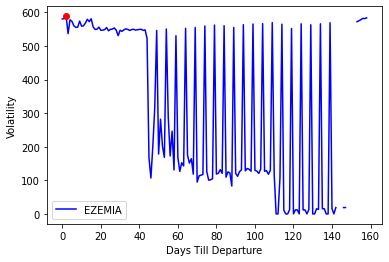

In [84]:
import matplotlib.pyplot as plt 


x=np.linspace(0,39,179)
l1 = EZEMIA['FARE']
print(len(l1))
x = EZEMIA['DaysTillDeparture']
plt.plot(l1,color = 'blue',label="EZEMIA")
plt.xlabel("Days Till Departure")
plt.ylabel("Volatility")
plt.legend(loc = "best")

l1_max=np.argmax(l1)
show_max='['+str(l1_max)+' '+str(l1[l1_max])+']'
plt.plot(l1_max,l1[l1_max],'ko', color = 'red') 

plt.show()

154


/var/folders/9f/ggcz5kw936jb850qk6q42z140000gn/T/ipykernel_70793/349717020.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  plt.plot(l1_max,l1[l1_max],'ko', color = 'red')


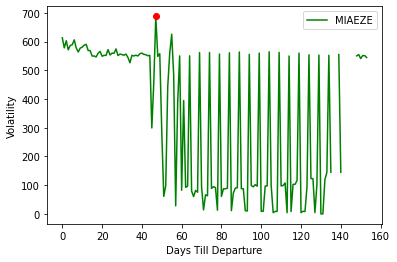

In [87]:
x=np.linspace(0,152,153)
l1 = MIAEZE['FARE']
print(len(l1))
x = MIAEZE['DaysTillDeparture']
plt.plot(l1,color = 'green',label="MIAEZE")
plt.xlabel("Days Till Departure")
plt.ylabel("Volatility")
plt.legend(loc = "best")

l1_max=np.argmax(l1)
show_max='['+str(l1_max)+' '+str(l1[l1_max])+']'
plt.plot(l1_max,l1[l1_max],'ko', color = 'red') 

plt.show()

180


/var/folders/9f/ggcz5kw936jb850qk6q42z140000gn/T/ipykernel_70793/872932344.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  plt.plot(l1_max,l1[l1_max],'ko', color = 'red')


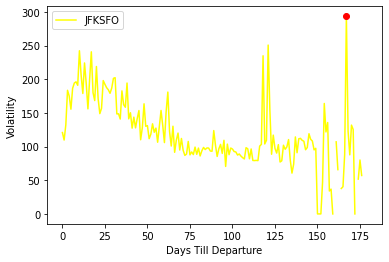

In [88]:
x=np.linspace(0,152,153)
l1 = JFKSFO['FARE']
print(len(l1))
x = JFKSFO['DaysTillDeparture']
plt.plot(l1,color = 'yellow',label="JFKSFO")
plt.xlabel("Days Till Departure")
plt.ylabel("Volatility")
plt.legend(loc = "best")

l1_max=np.argmax(l1)
show_max='['+str(l1_max)+' '+str(l1[l1_max])+']'
plt.plot(l1_max,l1[l1_max],'ko', color = 'red') 

plt.show()

208


/var/folders/9f/ggcz5kw936jb850qk6q42z140000gn/T/ipykernel_70793/2202507465.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  plt.plot(l1_max,l1[l1_max],'ko', color = 'red')


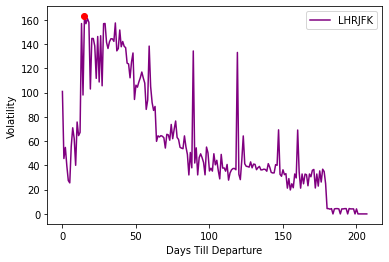

In [89]:
x=np.linspace(0,152,153)
l1 = LHRJFK['FARE']
print(len(l1))
x = LHRJFK['DaysTillDeparture']
plt.plot(l1,color = 'purple',label="LHRJFK")
plt.xlabel("Days Till Departure")
plt.ylabel("Volatility")
plt.legend(loc = "best")

l1_max=np.argmax(l1)
show_max='['+str(l1_max)+' '+str(l1[l1_max])+']'
plt.plot(l1_max,l1[l1_max],'ko', color = 'red') 

plt.show()

72


/var/folders/9f/ggcz5kw936jb850qk6q42z140000gn/T/ipykernel_70793/214908630.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  plt.plot(l1_max,l1[l1_max],'ko', color = 'yellow')


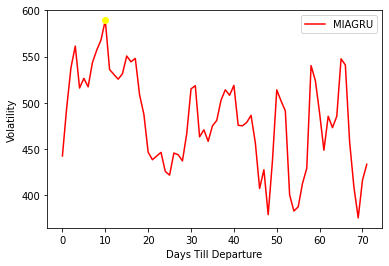

In [90]:
x=np.linspace(0,152,153)
l1 = MIAGRU['FARE']
print(len(l1))
x = MIAGRU['DaysTillDeparture']
plt.plot(l1,color = 'red',label="MIAGRU")
plt.xlabel("Days Till Departure")
plt.ylabel("Volatility")
plt.legend(loc = "best")

l1_max=np.argmax(l1)
show_max='['+str(l1_max)+' '+str(l1[l1_max])+']'
plt.plot(l1_max,l1[l1_max],'ko', color = 'yellow') 

plt.show()